<a href="https://colab.research.google.com/github/arvindsuresh-math/Aug-2025-Math-Solution-Classifier/blob/main/02_modeling_oct_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **0. Setup and Installations**

In [1]:
# --- Hugging Face Authentication (using Colab Secrets) ---
from google.colab import userdata
from huggingface_hub import login
print("Attempting Hugging Face login...")
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("Hugging Face login successful.")
except Exception as e:
    print(f"Could not log in. Please ensure 'HF_TOKEN' is a valid secret. Error: {e}")

Attempting Hugging Face login...
Hugging Face login successful.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Could not mount Google Drive. Error: {e}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [3]:
# --- Install Dependencies ---
!pip install pandas
!pip install pyarrow
!pip install sentence-transformers
!pip install scikit-learn
!pip install torch
!pip install tqdm

#### **2. Configuration and Helper Functions**

This section contains all hyperparameters and the new functions for data loading and splitting.

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import json
import time

In [5]:
# --- Seeding function for reproducibility ---
def set_seed(seed: int):
    """Sets the seed for all relevant RNGs to ensure reproducibility."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # for multi-GPU
        # These are crucial for reproducibility on GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"All random seeds set to {seed}.")

class Config:
    # --- Data and Environment ---
    CITY: str = "nyc"
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    DRIVE_SAVE_PATH: str = "/content/drive/MyDrive/Colab_Notebooks/Airbnb_Project/"

    # --- Data Pre-processing ---
    VAL_SIZE: float = 0.2

    # --- Reproducibility ---
    SEED: int = 42 # Master seed for the entire experiment

    # --- Model Training ---
    BATCH_SIZE: int = 1024
    LEARNING_RATE: float = 1e-3
    N_EPOCHS: int = 30

    # --- Early Stopping ---
    EARLY_STOPPING_PATIENCE: int = 5
    EARLY_STOPPING_MIN_DELTA: float = 0.05 # <-- CHANGED to a sensible value for RW-MSE in dollars

    # --- Logging ---
    LOG_EVERY_N_STEPS: int = 10 # Log and validate every N training steps

### **2. Data Loading and Splitting**

This function handles loading, outlier removal, and the 3-way stratified split.

In [6]:
def load_and_split_data(config: Config):
    """
    Loads data, removes price outliers, and performs a 3-way stratified split.
    """
    dataset_filename = f"{config.CITY}_final_modeling_dataset.parquet"
    dataset_path = f"./{dataset_filename}" # Assumes file in root Colab runtime

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"'{dataset_filename}' not found. Please upload the file to the Colab Runtime.")

    print(f"Loading dataset from: {dataset_path}")
    df = pd.read_parquet(dataset_path)

    # Remove price outliers (top/bottom 1%)
    price_q01 = df['target_price'].quantile(0.01)
    price_q99 = df['target_price'].quantile(0.99)
    df = df[(df['target_price'] >= price_q01) & (df['target_price'] <= price_q99)].copy()
    print(f"Removed price outliers. New size: {len(df):,} records.")

    # Create bins for stratifying continuous price
    df['price_bin'] = pd.cut(df['target_price'], bins=10, labels=False)

    # Create a combined key for 3-way stratification
    stratify_key = (
        df['neighbourhood_cleansed'].astype(str) + '_' +
        df['month'].astype(str) + '_' +
        df['price_bin'].astype(str)
    )

    # Handle small strata (<2 members)
    strata_counts = stratify_key.value_counts()
    valid_strata = strata_counts[strata_counts >= 2].index
    df_filtered = df[stratify_key.isin(valid_strata)].copy()
    print(f"Removed small strata. New size: {len(df_filtered):,} records.")

    # Perform stratified split
    train_indices, val_indices = train_test_split(
        df_filtered.index,
        test_size=config.VAL_SIZE,
        random_state=config.SEED,
        stratify=stratify_key[df_filtered.index]
    )

    train_df = df_filtered.loc[train_indices].copy().reset_index(drop=True)
    val_df = df_filtered.loc[val_indices].copy().reset_index(drop=True)

    print(f"Split complete. Training: {len(train_df):,}, Validation: {len(val_df):,}")

    print("\n--- Sample Record from Training Data ---")
    # Pretty-print the first record by transposing it
    print(train_df.head(1).T)

    return train_df, val_df

### **3. Feature Processor**

This class encapsulates the feature engineering logic as defined in `EMBEDDINGS.md`. It learns transformations (like vocabularies and scaling parameters) from the training data via the `.fit()` method. The `.transform()` method then consistently applies these learned transformations to any dataset, preventing data leakage. This is a crucial step for creating model-ready tensors from raw dataframes.

In [7]:
class FeatureProcessor:
    def __init__(self, embedding_dim_geo: int = 32):
        self.vocabs, self.scalers = {}, {}
        self.embedding_dim_geo = embedding_dim_geo
        self.categorical_cols = [
            "neighbourhood_cleansed",
            "property_type",
            "room_type",
            "bathrooms_type",
            "bedrooms",
            "beds",
            "bathrooms_numeric"
            ]
        self.numerical_cols = [
            "accommodates",
            "review_scores_rating",
            "review_scores_cleanliness",
            "review_scores_checkin",
            "review_scores_communication",
            "review_scores_location",
            "review_scores_value",
            "host_response_rate",
            "host_acceptance_rate"
            ]
        self.log_transform_cols = ["number_of_reviews_ltm"]
        self.boolean_cols = [
            "host_is_superhost",
            "host_identity_verified",
            "instant_bookable"
            ]

    def _create_positional_encoding(self, value, max_val):
        d = self.embedding_dim_geo
        if d % 2 != 0: raise ValueError("embedding_dim_geo must be even.")
        pe = np.zeros(d)
        position = (value / max_val) * 10000
        div_term = np.exp(np.arange(0, d, 2) * -(np.log(10000.0) / d))
        pe[0::2] = np.sin(position * div_term)
        pe[1::2] = np.cos(position * div_term)
        return pe

    def fit(self, df: pd.DataFrame):
        for col in self.categorical_cols:
            valid_uniques = df[col].dropna().unique().tolist()
            self.vocabs[col] = {val: i for i, val in enumerate(["<UNK>"] + sorted(valid_uniques))}
        for col in self.numerical_cols + self.log_transform_cols:
            vals = np.log1p(df[col]) if col in self.log_transform_cols else df[col]
            self.scalers[col] = {'mean': vals.mean(), 'std': vals.std()}

    def transform(self, df: pd.DataFrame) -> dict:
        df = df.copy()
        half_dim = self.embedding_dim_geo // 2
        lat_enc = df['latitude'].apply(lambda x: self._create_positional_encoding(x, 90)[:half_dim])
        lon_enc = df['longitude'].apply(lambda x: self._create_positional_encoding(x, 180)[:half_dim])

        # --- Axis 1: Location ---
        half_dim = self.embedding_dim_geo // 2
        lat_enc = df['latitude'].apply(lambda x: self._create_positional_encoding(x, 90)[:half_dim])
        lon_enc = df['longitude'].apply(lambda x: self._create_positional_encoding(x, 180)[:half_dim])
        geo_position = np.hstack([np.stack(lat_enc), np.stack(lon_enc)])
        neighbourhood = df["neighbourhood_cleansed"].apply(lambda x: self.vocabs["neighbourhood_cleansed"].get(x, 0)).values
        location_features = {"geo_position": geo_position, "neighbourhood": neighbourhood}

        # --- Axis 2: Size & Capacity ---
        size_features = {}
        for col in ["property_type", "room_type", "bathrooms_type", "bedrooms", "beds", "bathrooms_numeric"]:
            size_features[col] = df[col].apply(lambda x: self.vocabs[col].get(x, 0) if pd.notna(x) else 0).values
        size_features["accommodates"] = ((df["accommodates"] - self.scalers["accommodates"]["mean"]) / self.scalers["accommodates"]["std"]).values

        # --- Axis 3: Quality & Reputation ---
        quality_features = {}
        for col in self.numerical_cols:
            if col != "accommodates":
                quality_features[col] = ((df[col] - self.scalers[col]["mean"]) / self.scalers[col]["std"]).values
        quality_features["number_of_reviews_ltm"] = ((np.log1p(df["number_of_reviews_ltm"]) - self.scalers["number_of_reviews_ltm"]["mean"]) / self.scalers["number_of_reviews_ltm"]["std"]).values
        for col in self.boolean_cols:
            quality_features[col] = df[col].astype(float).values

        # --- Axis 5: Seasonality ---
        month_sin = np.sin(2 * np.pi * df["month"] / 12)
        month_cos = np.cos(2 * np.pi * df["month"] / 12)
        seasonality_features = {"cyclical": np.vstack([month_sin, month_cos]).T}

        return {
            "location": location_features,
            "size_capacity": size_features,
            "quality": quality_features,
            "amenities": {"text": df["amenities"].tolist()},
            "seasonality": seasonality_features,
            # "target_log_price": np.log1p(df["target_price"].values),
            "target_price": df["target_price"].values, # try without log to see if training is stable
            "sample_weight": df["estimated_occupancy_rate"].values
        }

### **4. AirbnbDataset Class**

The PyTorch `Dataset` class, which defines how to retrieve a single item from our processed feature dictionary.

In [8]:
class AirbnbPriceDataset(Dataset):
    def __init__(self, features: dict):
        self.features = features
        self.n_samples = len(features['sample_weight'])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index: int) -> dict:
        item = {}
        # Location
        item['loc_geo_position'] = self.features['location']['geo_position'][index]
        item['loc_neighbourhood'] = self.features['location']['neighbourhood'][index]

        # Size & Capacity
        for k, v in self.features['size_capacity'].items():
            item[f'size_{k}'] = v[index]

        # Quality
        for k, v in self.features['quality'].items():
            item[f'qual_{k}'] = v[index]

        # Amenities & Seasonality
        item['amenities_text'] = self.features['amenities']['text'][index]
        item['season_cyclical'] = self.features['seasonality']['cyclical'][index]

        # Target & Weight
        item['target'] = self.features['target_price'][index]
        item['sample_weight'] = self.features['sample_weight'][index]

        return item

### **5. Dataloader Creation**

A function to create the `DataLoader` instances, including the custom collate function for batch tokenization.

In [9]:
# (This cell replaces the 'preprocess_and_tensorize' and 'create_dataloaders' functions)

def preprocess_and_tensorize_CPU(processor, df):
    """
    Applies the feature processor and converts data to CPU tensors with correct dtypes.
    """
    features_cpu = processor.transform(df)
    features_tensor = {}

    for key, value in features_cpu.items():
        if key == 'amenities':
            features_tensor[key] = value # Keep raw text
        elif isinstance(value, dict):
            features_tensor[key] = {}
            for sub_key, sub_val in value.items():
                # --- CORRECTED DTYPE LOGIC ---
                # Use the lists from the processor to determine the correct dtype.
                # Categorical features need to be 'long' for embedding layers.
                # All other features (numerical, boolean, cyclical, positional) must be 'float'.
                if sub_key in processor.categorical_cols or sub_key == 'neighbourhood':
                    dtype = torch.long
                else:
                    dtype = torch.float32

                features_tensor[key][sub_key] = torch.from_numpy(sub_val).to(dtype=dtype)
        else: # Handles top-level items like target_log_price and sample_weight
            features_tensor[key] = torch.from_numpy(value).to(dtype=torch.float32)

    return features_tensor

def create_dataloaders(train_features_cpu, val_features_cpu, config: Config):
    """Creates high-performance, reproducible PyTorch DataLoaders."""

    # Tokenizer can still be on the GPU for speed, as it's used in the main process
    tokenizer_model = SentenceTransformer('BAAI/bge-small-en-v1.5', device=config.DEVICE)

    def custom_collate_fn(batch: list) -> dict:
        amenities_texts = [item.pop('amenities_text') for item in batch]
        collated_batch = {key: torch.stack([d[key] for d in batch]) for key in batch[0].keys()}
        # The tokenizer is called, but its output remains on CPU by default
        tokenized = tokenizer_model.tokenizer(
            amenities_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=128
        )
        collated_batch['amenities_tokens'] = tokenized
        return collated_batch

    train_dataset = AirbnbPriceDataset(train_features_cpu)
    val_dataset = AirbnbPriceDataset(val_features_cpu)

    g = torch.Generator()
    g.manual_seed(config.SEED)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate_fn,
        generator=g,
        pin_memory=True,
        num_workers=2
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn,
        pin_memory=True,
        num_workers=2
    )
    print(f"DataLoaders created with pin_memory=True and num_workers=2.")
    return train_loader, val_loader

### **6. Model Architecture**

This is the `AdditiveAxisModel`, our core neural network. As detailed in `MODELING.md`, it's a multi-headed architecture where each "head" or sub-network is responsible for a distinct feature axis (Location, Size, etc.). The final price is the sum of contributions from each axis plus a global bias. This design makes the model's predictions inherently explainable.

In [10]:
class AdditiveAxisModel(nn.Module):
    def __init__(self, processor: FeatureProcessor, device: str):
        super().__init__()
        self.vocabs, self.device = processor.vocabs, device
        self.embed_neighbourhood = nn.Embedding(len(self.vocabs['neighbourhood_cleansed']), 16)
        self.embed_property_type = nn.Embedding(len(self.vocabs['property_type']), 8)
        self.embed_room_type = nn.Embedding(len(self.vocabs['room_type']), 4)
        self.embed_bathrooms_type = nn.Embedding(len(self.vocabs['bathrooms_type']), 2)
        self.embed_bedrooms = nn.Embedding(len(self.vocabs['bedrooms']), 4)
        self.embed_beds = nn.Embedding(len(self.vocabs['beds']), 4)
        self.embed_bathrooms_numeric = nn.Embedding(len(self.vocabs['bathrooms_numeric']), 4)
        self.amenities_transformer = SentenceTransformer('BAAI/bge-small-en-v1.5', device=self.device)
        for param in self.amenities_transformer.parameters(): param.requires_grad = False
        self.loc_subnet = nn.Sequential(nn.Linear(48, 32), nn.ReLU(), nn.Linear(32, 1))
        self.size_subnet = nn.Sequential(nn.Linear(27, 32), nn.ReLU(), nn.Linear(32, 1))
        self.qual_subnet = nn.Sequential(nn.Linear(12, 32), nn.ReLU(), nn.Linear(32, 1))
        self.amenities_subnet = nn.Linear(384, 1)
        self.season_subnet = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
        self.global_bias = nn.Parameter(torch.randn(1))
        self.to(self.device)

    def forward(self, batch: dict) -> torch.Tensor:
        # Location
        loc_geo = batch['loc_geo_position']
        loc_hood_embed = self.embed_neighbourhood(batch['loc_neighbourhood'])
        loc_input = torch.cat([loc_geo, loc_hood_embed], dim=1)

        # Size
        size_embeds = [
            self.embed_property_type(batch['size_property_type']),
            self.embed_room_type(batch['size_room_type']),
            self.embed_bathrooms_type(batch['size_bathrooms_type']),
            self.embed_beds(batch['size_beds']),
            self.embed_bedrooms(batch['size_bedrooms']),
            self.embed_bathrooms_numeric(batch['size_bathrooms_numeric']),
            batch['size_accommodates'].unsqueeze(1)
            ]
        size_input = torch.cat(size_embeds, dim=1)

        # Quality
        qual_inputs = [
            batch['qual_review_scores_rating'].unsqueeze(1),
            batch['qual_review_scores_cleanliness'].unsqueeze(1),
            batch['qual_review_scores_checkin'].unsqueeze(1),
            batch['qual_review_scores_communication'].unsqueeze(1),
            batch['qual_review_scores_location'].unsqueeze(1),
            batch['qual_review_scores_value'].unsqueeze(1),
            batch['qual_host_response_rate'].unsqueeze(1),
            batch['qual_host_acceptance_rate'].unsqueeze(1),
            batch['qual_number_of_reviews_ltm'].unsqueeze(1),
            batch['qual_host_is_superhost'].unsqueeze(1),
            batch['qual_host_identity_verified'].unsqueeze(1),
            batch['qual_instant_bookable'].unsqueeze(1)
            ]
        qual_input = torch.cat(qual_inputs, dim=1)

        # Amenities - The key fix is here:
        amenities_tokens = batch['amenities_tokens'].to(self.device)
        amenities_embed = self.amenities_transformer(amenities_tokens)['sentence_embedding']

        # Get price contributions
        p_loc = self.loc_subnet(loc_input)
        p_size = self.size_subnet(size_input)
        p_qual = self.qual_subnet(qual_input)
        p_amenities = self.amenities_subnet(amenities_embed)
        p_season = self.season_subnet(batch['season_cyclical'])

        return (
            self.global_bias
            + p_loc
            + p_size
            + p_qual
            + p_amenities
            + p_season
          ).squeeze(-1)

### **7. Training Function**

This function orchestrates the training and validation loops for a given number of epochs.


In [11]:
def evaluate_model(model, data_loader, device):
    """Runs a full evaluation pass on the provided data_loader."""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            # Move all parts of the batch to the correct device
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    batch[key] = value.to(device, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items():
                        batch[key][sub_key] = sub_value.to(device, non_blocking=True)

            targets = batch['target']
            weights = batch['sample_weight']

            predictions = model(batch)
            loss = (weights * (predictions - targets)**2).mean().item()
            total_loss += loss

    return total_loss / len(data_loader)

def train_model(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: optim.Optimizer,
    config: Config
    ):
    """
    Trains the model with a Step 0 baseline and prints a concise, single-line log for each validation step.
    """
    print("\n--- Starting Model Training ---")
    start_time = time.time()

    history = []
    total_steps = len(train_loader) * config.N_EPOCHS
    global_step_count = 0
    patience_counter = 0
    early_stop_flag = False

    # --- Step 0: Initial Evaluation ---
    print("Performing Step 0 evaluation...")
    avg_val_loss_0 = evaluate_model(model, val_loader, config.DEVICE)
    first_train_batch = next(iter(train_loader))
    avg_train_loss_0 = evaluate_model(model, [first_train_batch], config.DEVICE)
    print("Step 0 evaluation complete.\n")

    best_val_loss = avg_val_loss_0 # Note: this is still the raw MSE
    best_model_state = model.state_dict()

    elapsed_seconds = time.time() - start_time
    elapsed_time_str = time.strftime('%H:%M:%S', time.gmtime(elapsed_seconds))

    step_stats_0 = {
        'Steps': 0, 'Epoch': 0.00,
        'Train RW-MSE ($)': np.sqrt(avg_train_loss_0),
        'Val RW-MSE ($)': np.sqrt(avg_val_loss_0),
        'Patience': 0,
        'Elapsed Time': elapsed_time_str
    }
    history.append(step_stats_0)

    # --- Print Header and Step 0 Results ---
    header = (
        f"{'Steps':>5} | {'Epoch':>5} | {'Train RW-MSE ($)':>16} | "
        f"{'Val RW-MSE ($)':>14} | {'Patience':>8} | {'Elapsed Time'}"
    )
    print(header)
    print("-" * len(header))

    log_line = (
        f"{step_stats_0['Steps']:>5d} | {step_stats_0['Epoch']:>5.2f} | "
        f"{step_stats_0['Train RW-MSE ($)']:>16.2f} | {step_stats_0['Val RW-MSE ($)']:>14.2f} | "
        f"{step_stats_0['Patience']:>8d} | {step_stats_0['Elapsed Time']}"
    )
    print(log_line)
    # --- End of Step 0 ---

    for epoch in range(config.N_EPOCHS):
        if early_stop_flag: break
        model.train()

        for i, batch in enumerate(train_loader):
            if early_stop_flag: break

            for key, value in batch.items():
                if isinstance(value, torch.Tensor): batch[key] = value.to(config.DEVICE, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items(): batch[key][sub_key] = sub_value.to(config.DEVICE, non_blocking=True)

            targets, weights = batch['target'], batch['sample_weight']
            predictions = model(batch)
            loss = (weights * (predictions - targets)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            global_step_count += 1

            if (global_step_count % config.LOG_EVERY_N_STEPS == 0) or (global_step_count == total_steps):
                avg_val_loss = evaluate_model(model, val_loader, config.DEVICE)

                # --- CORRECTED EARLY STOPPING LOGIC ---
                # Compare the square root of the loss (RW-MSE)
                current_rw_mse = np.sqrt(avg_val_loss)
                best_rw_mse = np.sqrt(best_val_loss)

                if current_rw_mse < best_rw_mse - config.EARLY_STOPPING_MIN_DELTA:
                    best_val_loss = avg_val_loss # Still save the raw MSE
                    patience_counter = 0
                    best_model_state = model.state_dict()
                else:
                    patience_counter += 1
                # --- END OF CORRECTION ---

                if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                    early_stop_flag = True

                elapsed_seconds = time.time() - start_time
                elapsed_time_str = time.strftime('%H:%M:%S', time.gmtime(elapsed_seconds))

                step_stats = {
                    'Steps': global_step_count, 'Epoch': epoch + (i + 1) / len(train_loader),
                    'Train RW-MSE ($)': np.sqrt(loss.item()),
                    'Val RW-MSE ($)': np.sqrt(avg_val_loss),
                    'Patience': patience_counter,
                    'Elapsed Time': elapsed_time_str
                }
                history.append(step_stats)

                log_line = (
                    f"{step_stats['Steps']:>5d} | {step_stats['Epoch']:>5.2f} | "
                    f"{step_stats['Train RW-MSE ($)']:>16.2f} | {step_stats['Val RW-MSE ($)']:>14.2f} | "
                    f"{step_stats['Patience']:>8d} | {step_stats['Elapsed Time']}"
                )
                print(log_line)

                if early_stop_flag:
                    print(f"\n--- Early Stopping Triggered at Step {global_step_count} ---")


    print("\n--- Training Complete ---")

    if best_model_state is not None:
        print(f"Loading best model state (Val RW-MSE ($): {np.sqrt(best_val_loss):.2f})")
        model.load_state_dict(best_model_state)

    return model, pd.DataFrame(history)

### **8. Main Execution Function**

This single cell runs the entire pipeline from start to finish using the settings defined in the `Config` class.

In [12]:
def save_artifacts(artifacts: dict, config: Config):
    """Saves the essential training artifacts to a single file."""
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename = f"{config.CITY}_artifacts_{timestamp}.pt"

    # Define paths for local runtime and Google Drive
    runtime_path = f"./{filename}"
    drive_path = os.path.join(config.DRIVE_SAVE_PATH, filename)

    # Ensure Google Drive directory exists
    os.makedirs(config.DRIVE_SAVE_PATH, exist_ok=True)

    print(f"\nSaving artifacts to {runtime_path} and {drive_path}...")
    torch.save(artifacts, runtime_path)
    torch.save(artifacts, drive_path)
    print("Artifacts saved successfully.")

def main(config: Config):
    """Runs the end-to-end training pipeline."""
    # 1. Load and split data
    train_df, val_df = load_and_split_data(config)

    # 2. Process features and move to GPU
    processor = FeatureProcessor()
    processor.fit(train_df)
    train_features_cpu = preprocess_and_tensorize_CPU(processor, train_df)
    val_features_cpu = preprocess_and_tensorize_CPU(processor, val_df)

    # 3. Create DataLoaders (pass CPU features)
    train_loader, val_loader = create_dataloaders(train_features_cpu, val_features_cpu, config)

    # 4. Initialize model and optimizer
    model = AdditiveAxisModel(processor, device=config.DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

    # 5. Run training
    trained_model, training_history = train_model(model, train_loader, val_loader, optimizer, config)

    # 6. Collate all artifacts into a single dictionary
    artifacts = {
        "config": config,
        "processor": processor,
        "model_state_dict": trained_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "history": training_history
    }

    # 7. Save artifacts and display final results
    save_artifacts(artifacts, config)

    print("\n--- Final Training Results ---")
    display(training_history)

    return artifacts

#### **9. Final execution cell**

Requires two steps-- First, instantiate a Config object (`config`, say), changing any attributes from the default as needed. Next, simply run `main(config)`

In [13]:
# Instantiate the configuration
config = Config()
set_seed(config.SEED)

print(f"Configuration loaded:")
print(f"Device: {config.DEVICE}")
print(f"City: {config.CITY}")
print(f"Seed: {config.SEED}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Number of Epochs: {config.N_EPOCHS}")
print(f"Logging Interval: {config.LOG_EVERY_N_STEPS}")
print("="*50)

# Run the end-to-end training pipeline
training_artifacts = main(config)

All random seeds set to 42.
Configuration loaded:
Device: cuda
City: nyc
Seed: 42
Batch Size: 1024
Learning Rate: 0.001
Number of Epochs: 30
Logging Interval: 10
Loading dataset from: ./nyc_final_modeling_dataset.parquet
Removed price outliers. New size: 81,643 records.
Removed small strata. New size: 79,485 records.
Split complete. Training: 63,588, Validation: 15,897

--- Sample Record from Training Data ---
                                                                             0
listing_id                                                  779010937952266773
year_month                                                             2024-11
target_price                                                              90.0
estimated_occupancy_rate                                              0.066667
latitude                                                              40.63478
longitude                                                             -73.9501
neighbourhood_cleansed           

,Steps,Epoch,Train RW-MSE ($),Val RW-MSE ($),Patience,Elapsed Time
0,0,0.000000,132.876529,123.029132,0,00:00:09
1,10,0.158730,114.933541,122.539381,0,00:00:20
2,20,0.317460,137.667554,122.020805,0,00:00:31
3,30,0.476190,119.901604,121.433085,0,00:00:42
4,40,0.634921,117.466651,120.751231,0,00:00:53
...,...,...,...,...,...,...
167,1670,26.507937,46.791989,43.381254,1,00:30:29
168,1680,26.666667,41.822130,43.395589,2,00:30:40
169,1690,26.825397,39.413002,43.363761,3,00:30:51
170,1700,26.984127,47.521359,43.354759,4,00:31:01


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_model_performance(model, data_loader, df, device):
    """
    Runs inference on a dataset and returns a detailed performance analysis,
    segmented by price range.
    """
    model.eval()
    predictions = []

    # We only need predictions, not targets from the loader, as they are in the df
    with torch.no_grad():
        for batch in data_loader:
            # Move all parts of the batch to the correct device
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    batch[key] = value.to(device, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items():
                        batch[key][sub_key] = sub_value.to(device, non_blocking=True)

            preds = model(batch)
            predictions.extend(preds.cpu().numpy())

    # Ensure the number of predictions matches the dataframe size
    # This handles the case where the last batch is smaller
    results_df = df.iloc[:len(predictions)].copy()
    results_df['predicted_price'] = predictions

    # Calculate errors
    results_df['absolute_error'] = (results_df['predicted_price'] - results_df['target_price']).abs()
    results_df['percentage_error'] = (results_df['absolute_error'] / results_df['target_price']) * 100

    # Create price bins for segmentation
    price_bins = [0, 75, 150, 250, 400, results_df['target_price'].max()]
    bin_labels = ['_'.join(map(str, map(int, i))) for i in zip(price_bins[:-1], price_bins[1:])]
    results_df['price_bin'] = pd.cut(results_df['target_price'], bins=price_bins, labels=bin_labels, right=False)


    # Aggregate performance by price bin
    performance_summary = results_df.groupby('price_bin', as_index=False).agg(
        num_listings=('listing_id', 'count'),
        mean_abs_error=('absolute_error', 'mean'),
        mean_abs_perc_error=('percentage_error', 'mean')
    )

    return performance_summary, results_df

In [15]:
# --- Main Analysis Execution ---

# 1. Load the artifacts from your training run
# Assumes 'training_artifacts' variable exists from the previous cell
processor = training_artifacts['processor']
config = training_artifacts['config']
model_state_dict = training_artifacts['model_state_dict']

# 2. Re-create the validation set and data loader
# This is necessary because the loader itself isn't saved in the artifacts
print("Re-creating validation data loader...")
_, val_df = load_and_split_data(config)
val_features_cpu = preprocess_and_tensorize_CPU(processor, val_df)
# We only need the validation loader, so we can ignore the training one
_, val_loader = create_dataloaders(None, val_features_cpu, config)
print("DataLoader created.")

# 3. Instantiate a new model and load the trained weights
print("Loading trained model...")
model = AdditiveAxisModel(processor, config.DEVICE)
model.load_state_dict(model_state_dict)
print("Model loaded.")

# 4. Run the performance analysis
print("\n--- Analyzing performance on the validation set ---")
performance_summary, detailed_results = analyze_model_performance(
    model=model,
    data_loader=val_loader,
    df=val_df,
    device=config.DEVICE
)

print("\nPerformance by Price Bracket:")
print(performance_summary.to_string(index=False, float_format="%.2f"))

# --- 5. Visualize the results ---
print("\nGenerating plot...")
plt.figure(figsize=(12, 6))
sns.barplot(data=performance_summary, x='price_bin', y='mean_abs_perc_error', palette='viridis')
plt.title('Mean Absolute Percentage Error (MAPE) by Price Bracket', fontsize=16)
plt.xlabel('True Price Range ($)', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Re-creating validation data loader...
Loading dataset from: ./nyc_final_modeling_dataset.parquet
Removed price outliers. New size: 81,643 records.
Removed small strata. New size: 79,485 records.
Split complete. Training: 63,588, Validation: 15,897

--- Sample Record from Training Data ---
                                                                             0
listing_id                                                  779010937952266773
year_month                                                             2024-11
target_price                                                              90.0
estimated_occupancy_rate                                              0.066667
latitude                                                              40.63478
longitude                                                             -73.9501
neighbourhood_cleansed                                                Flatbush
property_type                                               Entire rental unit

TypeError: 'NoneType' object is not subscriptable

In [17]:
training_artifacts.keys()

dict_keys(['config', 'processor', 'model_state_dict', 'optimizer_state_dict', 'history'])

Unpacking artifacts...
Recreating data splits and data loaders...
Loading dataset from: ./nyc_final_modeling_dataset.parquet
Removed price outliers. New size: 81,643 records.
Removed small strata. New size: 79,485 records.
Split complete. Training: 63,588, Validation: 15,897

--- Sample Record from Training Data ---
                                                                             0
listing_id                                                  779010937952266773
year_month                                                             2024-11
target_price                                                              90.0
estimated_occupancy_rate                                              0.066667
latitude                                                              40.63478
longitude                                                             -73.9501
neighbourhood_cleansed                                                Flatbush
property_type                                     

/tmp/ipython-input-2216578138.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_summary = results_df.groupby('price_bin').agg(
/tmp/ipython-input-2216578138.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  performance_summary = results_df.groupby('price_bin').agg(
/tmp/ipython-input-2216578138.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=train_summary, x='price_bin', y='mean_abs_perc_error', palette='viridis')
/tmp/ip


Validation Set Performance by Price Bracket:
     price_bin  num_listings  mean_abs_error  mean_abs_perc_error
   [0.0, 75.0)          2433           36.82                66.85
 [75.0, 150.0)          6080           49.01                45.41
[150.0, 250.0)          4399           53.01                28.56
[250.0, 400.0)          2060           68.87                22.42
[400.0, 963.0)           925          189.24                33.25

Generating plots...


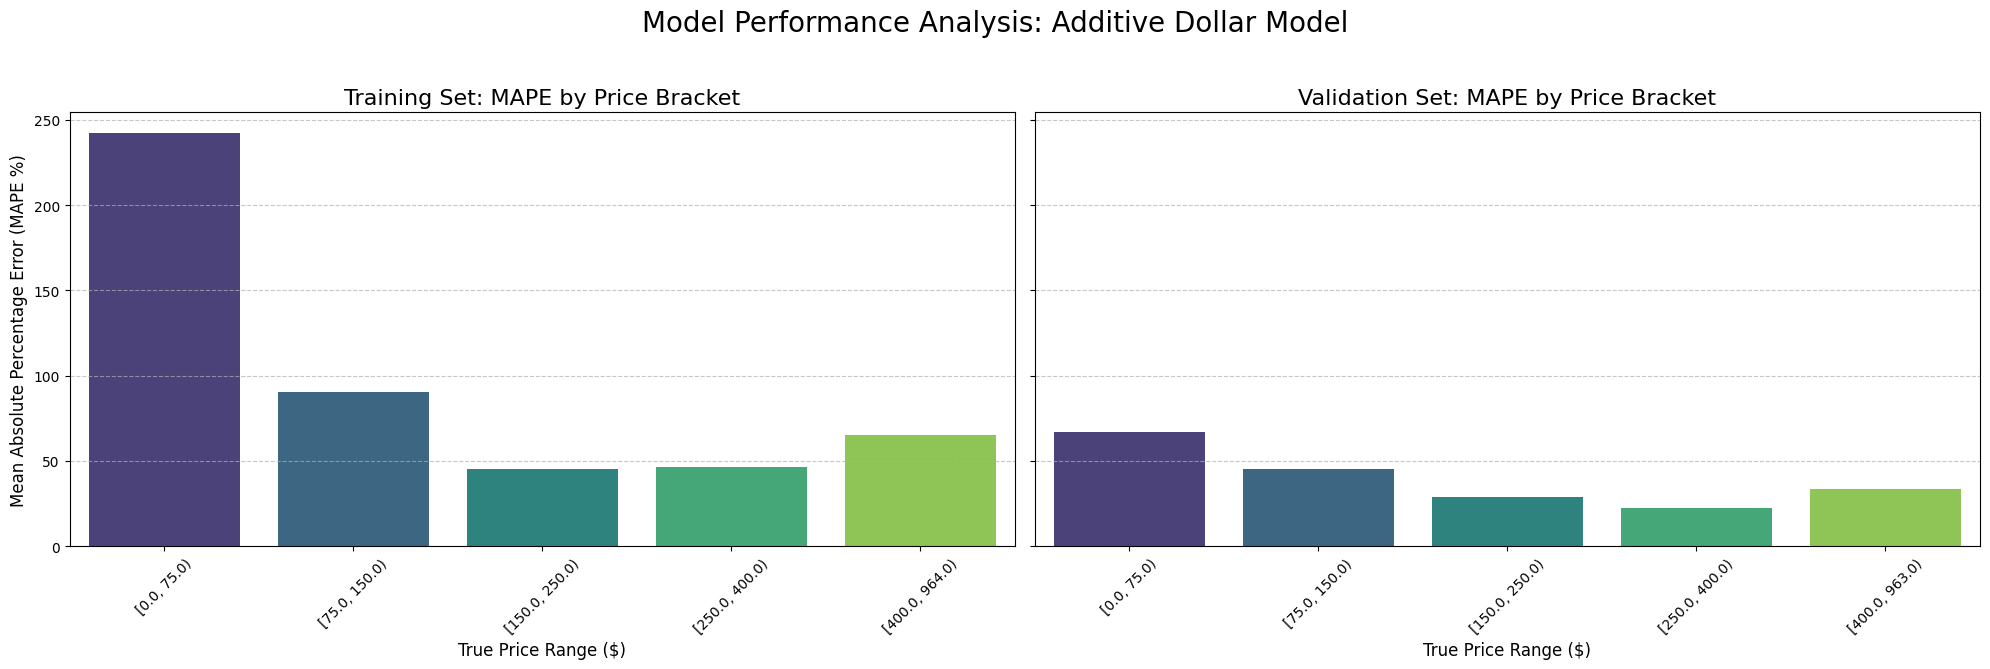

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_model_performance(model, data_loader, df, device):
    """
    Runs inference on a dataset and returns a detailed performance analysis,
    segmented by price range.
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    batch[key] = value.to(device, non_blocking=True)
                elif isinstance(value, dict):
                    for sub_key, sub_value in value.items():
                        batch[key][sub_key] = sub_value.to(device, non_blocking=True)

            preds = model(batch)
            predictions.extend(preds.cpu().numpy())

    results_df = df.iloc[:len(predictions)].copy()
    results_df['predicted_price'] = predictions

    results_df['absolute_error'] = (results_df['predicted_price'] - results_df['target_price']).abs()
    results_df['percentage_error'] = (results_df['absolute_error'] / results_df['target_price']) * 100

    price_bins = [0, 75, 150, 250, 400, results_df['target_price'].max() + 1]
    results_df['price_bin'] = pd.cut(results_df['target_price'], bins=price_bins, right=False)

    performance_summary = results_df.groupby('price_bin').agg(
        num_listings=('listing_id', 'count'),
        mean_abs_error=('absolute_error', 'mean'),
        mean_abs_perc_error=('percentage_error', 'mean')
    ).reset_index()

    return performance_summary, results_df

# --- Performance Analysis ---

# 1. Unpack the necessary components from your saved artifacts
print("Unpacking artifacts...")
processor = training_artifacts['processor']
config = training_artifacts['config']
model_state_dict = training_artifacts['model_state_dict']

# 2. Recreate the data splits and data loaders exactly as they were during training
print("Recreating data splits and data loaders...")
train_df, val_df = load_and_split_data(config)
train_features_cpu = preprocess_and_tensorize_CPU(processor, train_df)
val_features_cpu = preprocess_and_tensorize_CPU(processor, val_df)
train_loader, val_loader = create_dataloaders(train_features_cpu, val_features_cpu, config)
print("Data loaders recreated.")

# 3. Instantiate a new model and load the trained (best) weights
print("Loading trained model...")
model = AdditiveAxisModel(processor, config.DEVICE)
model.load_state_dict(model_state_dict)
print("Model loaded.")

# 4. Analyze performance on the TRAINING set
print("\n--- Analyzing performance on the TRAINING set ---")
train_summary, _ = analyze_model_performance(model, train_loader, train_df, config.DEVICE)
print("\nTraining Set Performance by Price Bracket:")
print(train_summary.to_string(index=False, float_format="%.2f"))

# 5. Analyze performance on the VALIDATION set
print("\n--- Analyzing performance on the VALIDATION set ---")
val_summary, _ = analyze_model_performance(model, val_loader, val_df, config.DEVICE)
print("\nValidation Set Performance by Price Bracket:")
print(val_summary.to_string(index=False, float_format="%.2f"))

# 6. Generate separate plots
print("\nGenerating plots...")
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle('Model Performance Analysis: Additive Dollar Model', fontsize=20)

# Plot for Training Data
sns.barplot(ax=axes[0], data=train_summary, x='price_bin', y='mean_abs_perc_error', palette='viridis')
axes[0].set_title('Training Set: MAPE by Price Bracket', fontsize=16)
axes[0].set_xlabel('True Price Range ($)', fontsize=12)
axes[0].set_ylabel('Mean Absolute Percentage Error (MAPE %)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Validation Data
sns.barplot(ax=axes[1], data=val_summary, x='price_bin', y='mean_abs_perc_error', palette='viridis')
axes[1].set_title('Validation Set: MAPE by Price Bracket', fontsize=16)
axes[1].set_xlabel('True Price Range ($)', fontsize=12)
axes[1].set_ylabel('') # Hide redundant y-axis label
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()